## **Matriz de correlación de los activos**

Calculando correlaciones entre los 50 activos...
¡Gráfico guardado como 'matriz_correlacion_completa.png'!


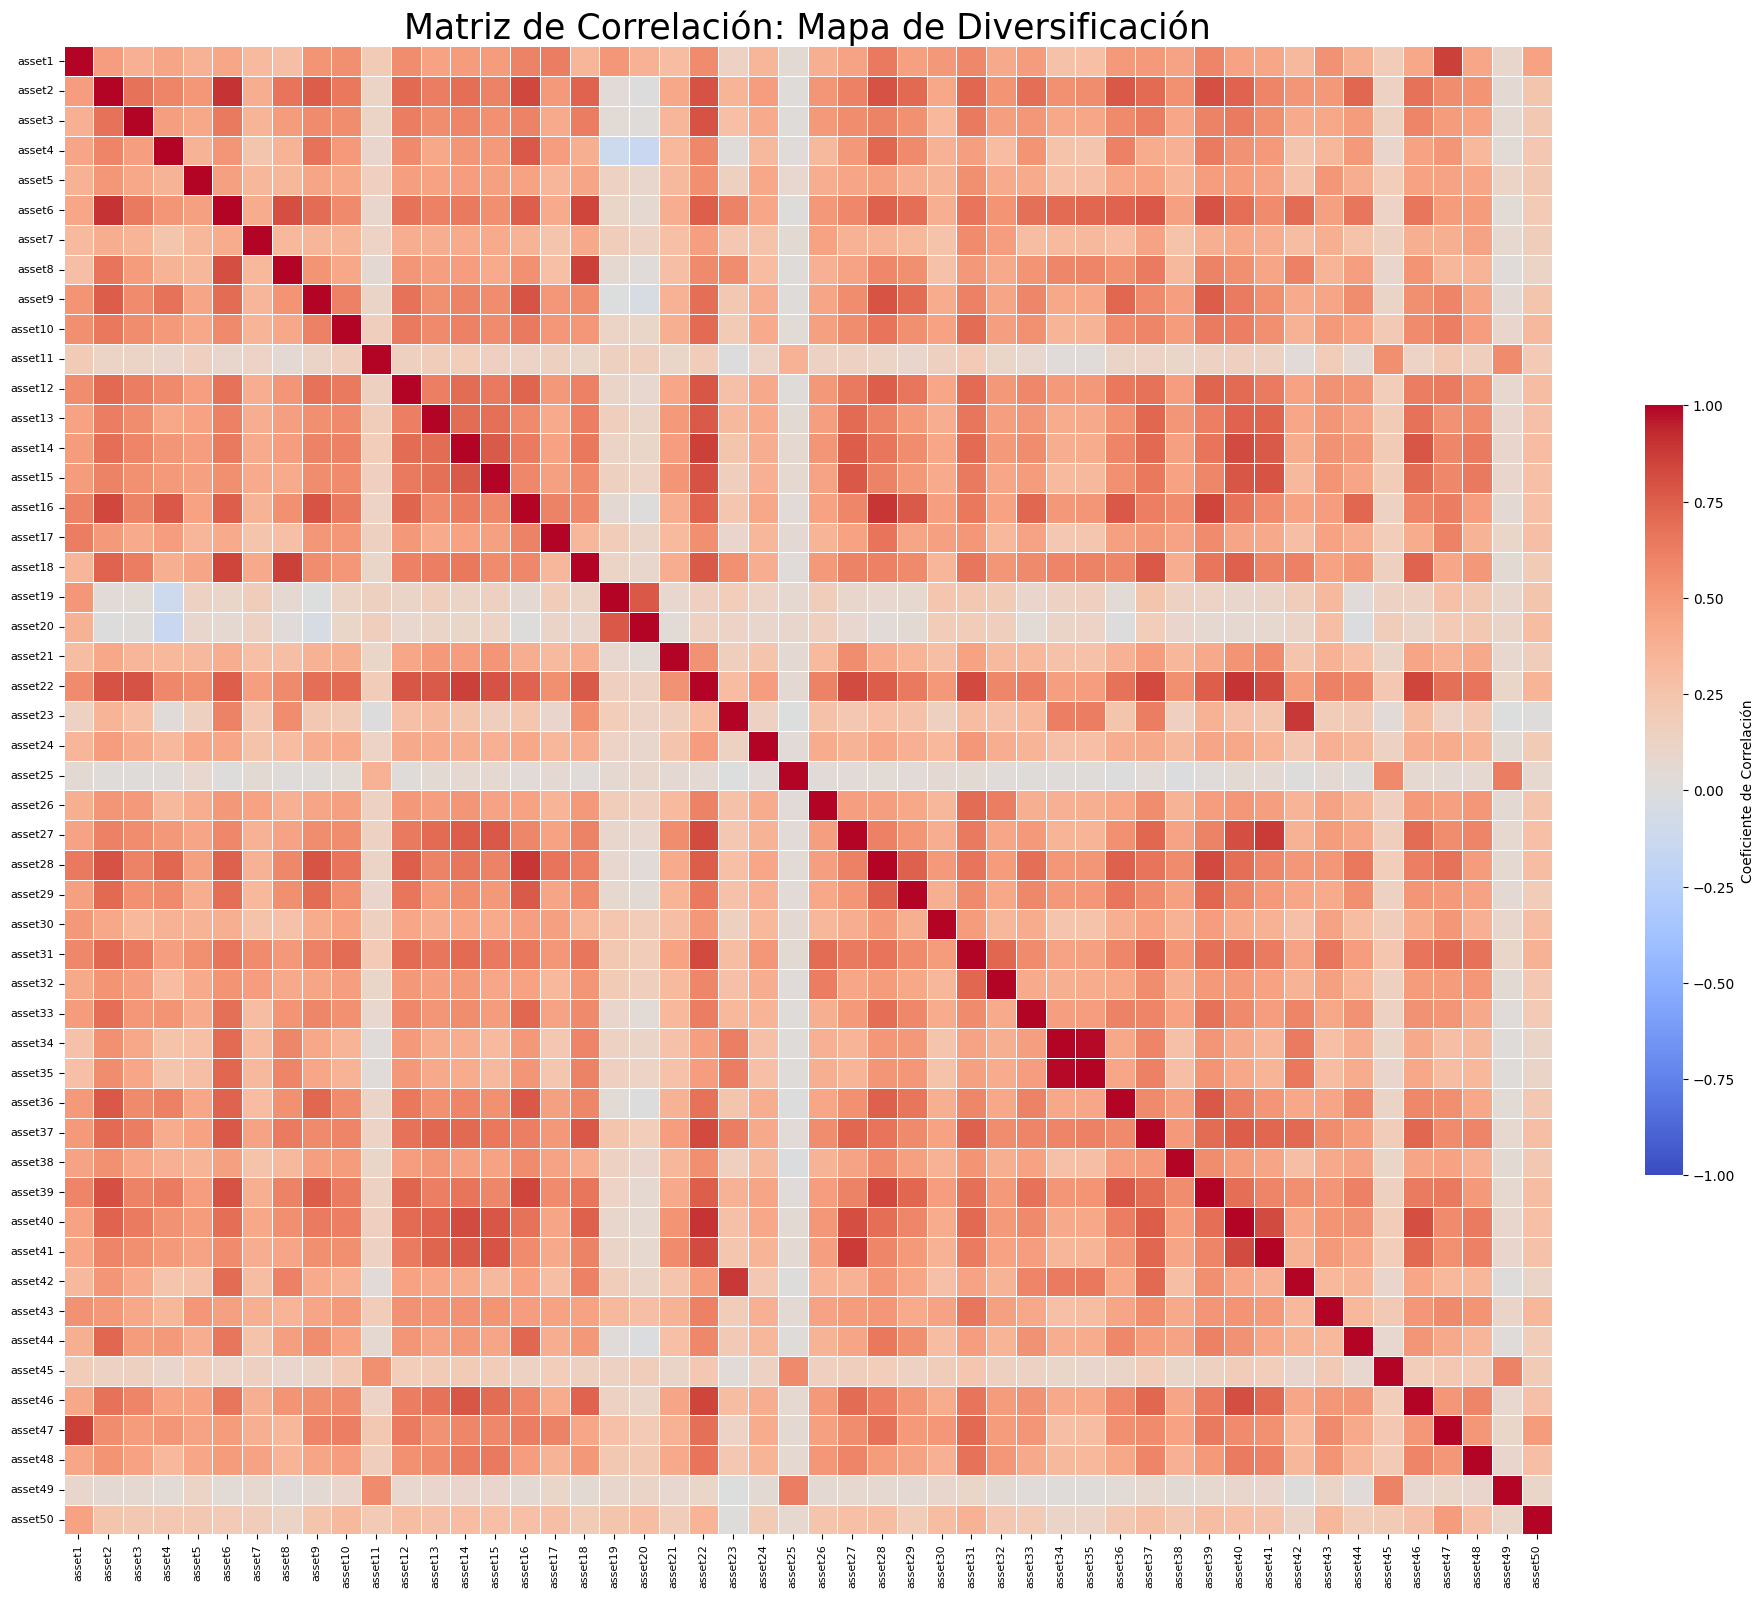


--- TOP 5 PARES PARA DIVERSIFICAR (Menor Correlación) ---
asset20  asset4    -0.146724
asset4   asset20   -0.146724
         asset19   -0.116239
asset19  asset4    -0.116239
asset20  asset9    -0.044746
asset9   asset20   -0.044746
asset38  asset25   -0.013893
asset25  asset38   -0.013893
asset44  asset20   -0.008397
asset20  asset44   -0.008397
dtype: float64


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def mostrar_matriz_correlacion():
    print("Calculando correlaciones entre los 50 activos...")

    # 1. Cargar Datos
    try:
        df = pd.read_csv('prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    except FileNotFoundError:
        print("Error: Asegúrate de tener el archivo .csv en la misma carpeta.")
        return

    # 2. Calcular la Matriz de Correlación
    # (Esto calcula el coeficiente de Pearson para cada par de activos)
    corr_matrix = df.corr()

    # 3. Configurar el Gráfico (Heatmap)
    plt.figure(figsize=(24, 20)) # Tamaño grande para que se lean las etiquetas
    
    # Crear el mapa de calor
    # cmap='coolwarm': 
    #   - Rojo Intenso = Correlación +1 (Se mueven idénticos -> Malo para diversificar)
    #   - Azul Intenso = Correlación -1 (Se mueven opuestos -> Perfecto para cubrir)
    #   - Blanco/Gris = Correlación 0 (No tienen nada que ver -> Bueno para diversificar)
    sns.heatmap(corr_matrix, 
                annot=False,       # Ponemos False porque 2500 números serían ilegibles
                cmap='coolwarm',   
                center=0,          # El centro (blanco) es correlación cero
                vmin=-1, vmax=1,   # Límites de la escala de color
                square=True,       # Celdas cuadradas
                linewidths=0.5,    # Líneas para separar celdas
                cbar_kws={"shrink": 0.5, "label": "Coeficiente de Correlación"})

    plt.title('Matriz de Correlación: Mapa de Diversificación', fontsize=25)
    plt.xticks(rotation=90, fontsize=8) # Rotar etiquetas eje X
    plt.yticks(rotation=0, fontsize=8)  # Etiquetas eje Y rectas

    # 4. Guardar y Mostrar
    output_file = 'matriz_correlacion_completa.png'
    plt.savefig(output_file, dpi=300) # Alta calidad
    print(f"¡Gráfico guardado como '{output_file}'!")
    plt.show()
    
    # 5. BONUS: Chivatazo de los mejores pares
    # Vamos a buscar matemáticamente los pares con menor correlación
    # Aplanamos la matriz y eliminamos la diagonal (correlación 1 consigo mismo)
    corr_pairs = corr_matrix.unstack().sort_values()
    print("\n--- TOP 5 PARES PARA DIVERSIFICAR (Menor Correlación) ---")
    print(corr_pairs.head(10)) # Muestra los pares más negativos (Azul oscuro)

if __name__ == "__main__":
    mostrar_matriz_correlacion()

Generando Mapa de Riesgo-Retorno...
Recalculando Cartera Lunes...
Recalculando Cartera Martes...

¡Gráfico generado exitosamente: mapa_estrategia.png!


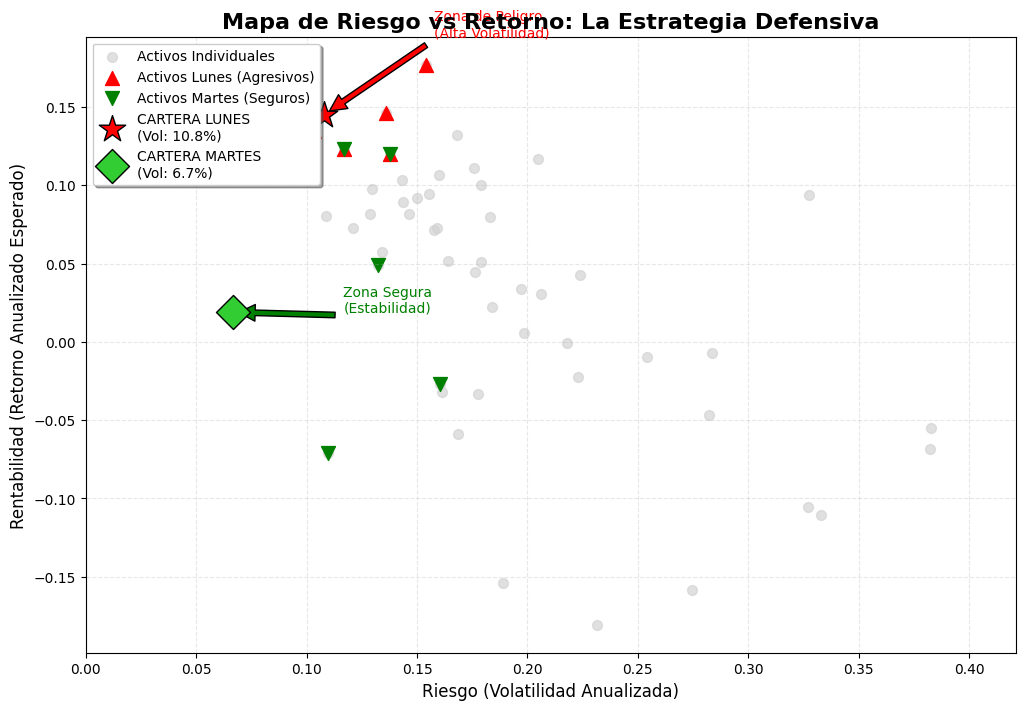

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def plot_risk_return_map():
    print("Generando Mapa de Riesgo-Retorno...")
    
    # 1. Cargar Datos
    try:
        df = pd.read_csv('prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    except FileNotFoundError:
        print("Error: No se encuentra el archivo .csv")
        return

    returns = df.values
    assets = df.columns
    n_assets = len(assets)

    # 2. Métricas Anualizadas de los Activos Individuales
    # (Multiplicamos por 252 para anualizar retorno, y por raiz(252) para volatilidad)
    mu_daily = np.mean(returns, axis=0)
    vol_daily = np.std(returns, axis=0)
    
    mu_ann = mu_daily * 252
    vol_ann = vol_daily * np.sqrt(252)

    # ---------------------------------------------------------
    # 3. Reconstruir Cartera LUNES (Francotirador - Max Sharpe Limitado)
    # ---------------------------------------------------------
    print("Recalculando Cartera Lunes...")
    Sigma = np.cov(returns, rowvar=False)
    rf = 0.0
    
    # Pre-selección Top 5 por Sharpe simple
    sharpes_simples = mu_daily / vol_daily
    top_5_lunes = np.argsort(sharpes_simples)[-5:]
    
    # Optimizar con límite 35%
    w_lunes = cp.Variable(5)
    mu_5_lunes = mu_daily[top_5_lunes]
    Sigma_5_lunes = Sigma[np.ix_(top_5_lunes, top_5_lunes)]
    
    risk_lunes = cp.quad_form(w_lunes, Sigma_5_lunes)
    prob_lunes = cp.Problem(cp.Minimize(risk_lunes), 
                            [(mu_5_lunes - rf) @ w_lunes == 1, 
                             w_lunes >= 0, 
                             w_lunes <= 0.35 * cp.sum(w_lunes)])
    try:
        prob_lunes.solve(solver=cp.SCS)
    except:
        prob_lunes.solve()
        
    pesos_lunes = w_lunes.value / np.sum(w_lunes.value)
    
    # Métricas Lunes
    ret_lunes = np.sum(pesos_lunes * mu_ann[top_5_lunes])
    vol_lunes = np.sqrt(np.dot(pesos_lunes.T, np.dot(Sigma_5_lunes * 252, pesos_lunes)))

    # ---------------------------------------------------------
    # 4. Reconstruir Cartera MARTES (Defensiva - Min Var)
    # ---------------------------------------------------------
    print("Recalculando Cartera Martes...")
    # Selección: Top 5 menor volatilidad (aproximación rápida a seguros)
    # O mejor: Usamos la MinVar Global real para seleccionar los activos
    w_global = cp.Variable(n_assets)
    prob_global = cp.Problem(cp.Minimize(cp.quad_form(w_global, Sigma)), 
                             [cp.sum(w_global) == 1, w_global >= 0])
    prob_global.solve(solver=cp.SCS)
    top_5_martes = np.argsort(w_global.value)[-5:]
    
    # Optimizar 90% en esos 5
    w_martes = cp.Variable(5)
    Sigma_5_martes = Sigma[np.ix_(top_5_martes, top_5_martes)]
    prob_martes = cp.Problem(cp.Minimize(cp.quad_form(w_martes, Sigma_5_martes)),
                             [cp.sum(w_martes) == 0.9, w_martes >= 0])
    prob_martes.solve()
    
    pesos_martes = w_martes.value # Suman 0.9
    
    # Métricas Martes (El 10% restante está en RF con vol=0 y ret=0)
    ret_martes = np.sum(pesos_martes * mu_ann[top_5_martes] * 252 / 252) # Ya anualizado
    vol_martes = np.sqrt(np.dot(pesos_martes.T, np.dot(Sigma_5_martes * 252, pesos_martes)))

    # ---------------------------------------------------------
    # 5. GENERAR EL GRÁFICO
    # ---------------------------------------------------------
    plt.figure(figsize=(12, 8))
    
    # A. Nube de Activos (Puntos Grises)
    plt.scatter(vol_ann, mu_ann, color='lightgray', s=50, alpha=0.7, label='Activos Individuales')
    
    # B. Activos Seleccionados Lunes (Triángulos Rojos)
    plt.scatter(vol_ann[top_5_lunes], mu_ann[top_5_lunes], color='red', marker='^', s=100, label='Activos Lunes (Agresivos)')
    
    # C. Activos Seleccionados Martes (Triángulos Verdes)
    plt.scatter(vol_ann[top_5_martes], mu_ann[top_5_martes], color='green', marker='v', s=100, label='Activos Martes (Seguros)')
    
    # D. Las dos Carteras (Grandes Marcadores)
    plt.scatter(vol_lunes, ret_lunes, color='red', marker='*', s=400, edgecolor='black', zorder=5,
                label=f'CARTERA LUNES\n(Vol: {vol_lunes:.1%})')
    plt.scatter(vol_martes, ret_martes, color='limegreen', marker='D', s=300, edgecolor='black', zorder=5,
                label=f'CARTERA MARTES\n(Vol: {vol_martes:.1%})')

    # Etiquetas y Estilo
    plt.title('Mapa de Riesgo vs Retorno: La Estrategia Defensiva', fontsize=16, fontweight='bold')
    plt.xlabel('Riesgo (Volatilidad Anualizada)', fontsize=12)
    plt.ylabel('Rentabilidad (Retorno Anualizado Esperado)', fontsize=12)
    
    # Flechas explicativas
    plt.annotate('Zona de Peligro\n(Alta Volatilidad)', xy=(vol_lunes, ret_lunes), xytext=(vol_lunes+0.05, ret_lunes+0.05),
                 arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')
                 
    plt.annotate('Zona Segura\n(Estabilidad)', xy=(vol_martes, ret_martes), xytext=(vol_martes+0.05, ret_martes),
                 arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')

    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.xlim(0, max(vol_ann)*1.1) # Empezar eje X en 0 para ver la magnitud del riesgo
    
    # Guardar y Mostrar
    nombre_imagen = 'mapa_estrategia.png'
    plt.savefig(nombre_imagen)
    print(f"\n¡Gráfico generado exitosamente: {nombre_imagen}!")
    plt.show()

if __name__ == "__main__":
    plot_risk_return_map()

## **Gráfica Cartera 1 y 2 sobre la frontera eficiente**

--- Generando Gráfico Evolutivo: Lunes a Viernes ---
Calculando curva de frontera eficiente...
Calculando Lunes...
Calculando Martes...
Calculando Miércoles...
Calculando Jueves...
Calculando Viernes (Búnker de Calidad)...

¡Gráfica guardada como 'markowitz_evolution_final_friday.png'!


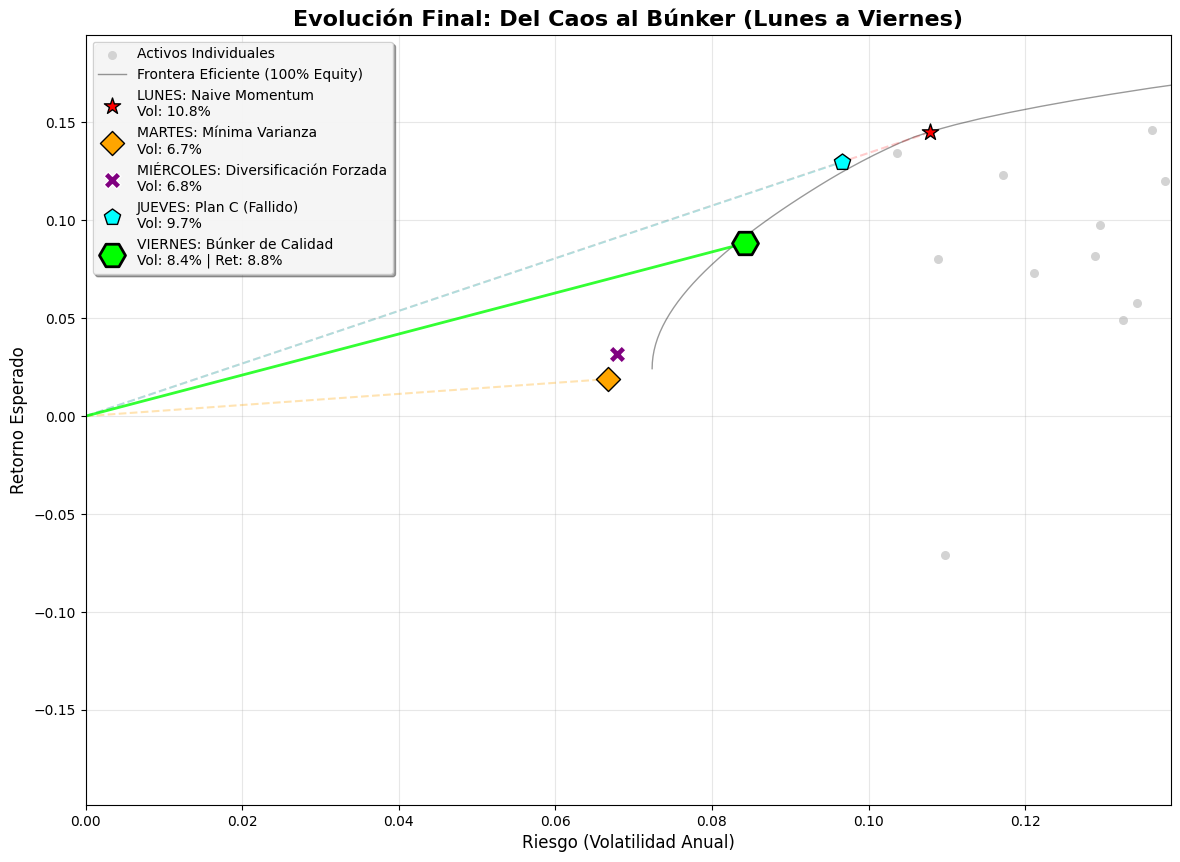

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def plot_markowitz_full_evolution_final_friday():
    print("--- Generando Gráfico Evolutivo: Lunes a Viernes ---")
    
    # 1. Cargar Datos
    try:
        df = pd.read_csv('prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    except FileNotFoundError:
        print("Error: No se encuentra el archivo .csv")
        return

    returns = df.values
    assets = df.columns
    n_assets = len(assets)

    # Métricas Anualizadas
    mu_daily = np.mean(returns, axis=0)
    Sigma_daily = np.cov(returns, rowvar=False)
    
    mu_ann = mu_daily * 252
    Sigma_ann = Sigma_daily * 252

    # ---------------------------------------------------------
    # 2. CALCULAR LA FRONTERA EFICIENTE (Contexto Visual)
    # ---------------------------------------------------------
    print("Calculando curva de frontera eficiente...")
    
    w = cp.Variable(n_assets)
    risk = cp.quad_form(w, Sigma_ann)
    ret = mu_ann @ w
    
    # Puntos extremos
    prob_min_var = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1, w >= 0])
    prob_min_var.solve(solver=cp.SCS)
    ret_min = ret.value
    ret_max = np.max(mu_ann)
    
    # Puntos intermedios
    target_returns = np.linspace(ret_min, ret_max, 50)
    frontier_vol = []
    frontier_ret = []

    for target in target_returns:
        prob = cp.Problem(cp.Minimize(risk), 
                          [cp.sum(w) == 1, w >= 0, ret == target])
        try:
            prob.solve(solver=cp.SCS)
            if prob.status == 'optimal':
                frontier_vol.append(np.sqrt(risk.value))
                frontier_ret.append(target)
        except:
            pass

    # ---------------------------------------------------------
    # 3. RECONSTRUCCIÓN DE CARTERAS (Lunes - Jueves)
    # ---------------------------------------------------------
    
    # --- A. LUNES: Momentum/Sharpe (Naive) ---
    print("Calculando Lunes...")
    sharpes = mu_daily / np.sqrt(np.diag(Sigma_daily))
    top5_lunes = np.argsort(sharpes)[-5:]
    
    w_lun = cp.Variable(5)
    mu_5_lun = mu_daily[top5_lunes]
    sig_5_lun = Sigma_daily[np.ix_(top5_lunes, top5_lunes)]
    
    prob_lun = cp.Problem(cp.Minimize(cp.quad_form(w_lun, sig_5_lun)), 
                          [(mu_5_lun) @ w_lun == 1, w_lun >= 0, w_lun <= 0.35*cp.sum(w_lun)])
    try: prob_lun.solve(solver=cp.SCS)
    except: prob_lun.solve()
    
    pesos_lun = w_lun.value / np.sum(w_lun.value)
    ret_lunes = np.sum(pesos_lun * mu_ann[top5_lunes])
    vol_lunes = np.sqrt(pesos_lun.T @ Sigma_ann[np.ix_(top5_lunes, top5_lunes)] @ pesos_lun)

    # --- Pre-cálculo Defensivo Global ---
    w_glo = cp.Variable(n_assets)
    cp.Problem(cp.Minimize(cp.quad_form(w_glo, Sigma_daily)), [cp.sum(w_glo)==1, w_glo>=0]).solve(solver=cp.SCS)
    top5_defensivos = np.argsort(w_glo.value)[-5:] 
    sig_5_def = Sigma_daily[np.ix_(top5_defensivos, top5_defensivos)]
    
    # --- B. MARTES: Defensiva Concentrada ---
    print("Calculando Martes...")
    w_mar = cp.Variable(5)
    prob_mar = cp.Problem(cp.Minimize(cp.quad_form(w_mar, sig_5_def)), 
                          [cp.sum(w_mar)==0.9, w_mar>=0])
    prob_mar.solve()
    
    pesos_mar = w_mar.value
    ret_martes = np.sum(pesos_mar * mu_ann[top5_defensivos]) 
    vol_martes = np.sqrt(pesos_mar.T @ Sigma_ann[np.ix_(top5_defensivos, top5_defensivos)] @ pesos_mar)

    # --- C. MIÉRCOLES: Defensiva Diversificada (Error) ---
    print("Calculando Miércoles...")
    w_mier = cp.Variable(5)
    prob_mier = cp.Problem(cp.Minimize(cp.quad_form(w_mier, sig_5_def)), 
                           [cp.sum(w_mier)==0.9, w_mier>=0, w_mier<=0.22]) 
    prob_mier.solve()
    
    pesos_mier = w_mier.value
    ret_miercoles = np.sum(pesos_mier * mu_ann[top5_defensivos])
    vol_miercoles = np.sqrt(pesos_mier.T @ Sigma_ann[np.ix_(top5_defensivos, top5_defensivos)] @ pesos_mier)

    # --- D. JUEVES: ESTRATEGIA "ÉLITE HÍBRIDA" (PLAN C) ---
    print("Calculando Jueves...")
    indices_elite = [5, 35, 22, 7, 44, 4, 19]
    mu_elite = mu_ann[indices_elite]
    Sigma_elite = Sigma_ann[np.ix_(indices_elite, indices_elite)]
    
    w_jue = cp.Variable(len(indices_elite))
    risk_jue = cp.quad_form(w_jue, Sigma_elite)
    ret_jue_obj = mu_elite @ w_jue
    gamma = cp.Parameter(nonneg=True)
    
    # Jueves (90% Expo + 30% Limite)
    prob_jue = cp.Problem(cp.Maximize(ret_jue_obj - gamma * risk_jue), 
                          [cp.sum(w_jue) == 0.90, w_jue >= 0, w_jue <= 0.30])
    
    best_sharpe = -np.inf
    best_w_jue = None
    
    for g_val in [0.5, 1.0, 2.0, 5.0, 10.0]:
        gamma.value = g_val
        try:
            prob_jue.solve(solver=cp.SCS)
            if w_jue.value is not None:
                val_w = w_jue.value
                val_vol = np.sqrt(val_w.T @ Sigma_elite @ val_w)
                if val_vol > 1e-5:
                    sharpe = (val_w @ mu_elite) / val_vol
                    if sharpe > best_sharpe:
                        best_sharpe = sharpe
                        best_w_jue = val_w
        except: pass
            
    ret_jueves = best_w_jue @ mu_elite
    vol_jueves = np.sqrt(best_w_jue.T @ Sigma_elite @ best_w_jue)

    # ---------------------------------------------------------
    # >>> E. VIERNES: BÚNKER DE CALIDAD (NUEVO) <<<
    # ---------------------------------------------------------
    print("Calculando Viernes (Búnker de Calidad)...")
    
    # 1. Filtro: Seleccionar solo activos con rentabilidad positiva
    indices_viernes = []
    for i in range(n_assets):
        if mu_ann[i] > 0: # Solo si ganan dinero
            indices_viernes.append(i)
            
    mu_vie_sub = mu_ann[indices_viernes]
    Sig_vie_sub = Sigma_ann[np.ix_(indices_viernes, indices_viernes)]
    
    # 2. Optimización: Mínima Varianza pura sobre los "buenos"
    w_vie = cp.Variable(len(indices_viernes))
    risk_vie = cp.quad_form(w_vie, Sig_vie_sub)
    
    # Restricciones Viernes: 90% Invertido (10% Cash) + Max 30% por activo
    prob_vie = cp.Problem(cp.Minimize(risk_vie), 
                          [cp.sum(w_vie) == 0.90, 
                           w_vie >= 0, 
                           w_vie <= 0.30])
    
    prob_vie.solve(solver=cp.SCS)
    
    val_w_vie = w_vie.value
    ret_viernes = val_w_vie @ mu_vie_sub
    vol_viernes = np.sqrt(val_w_vie.T @ Sig_vie_sub @ val_w_vie)

    # ---------------------------------------------------------
    # 4. GRAFICAR
    # ---------------------------------------------------------
    plt.figure(figsize=(14, 10))
    
    # A. Frontera y Activos
    plt.scatter(np.sqrt(np.diag(Sigma_ann)), mu_ann, c='lightgray', s=30, label='Activos Individuales')
    plt.plot(frontier_vol, frontier_ret, 'k-', linewidth=1, alpha=0.4, label='Frontera Eficiente (100% Equity)')
    
    # B. Puntos de las Estrategias
    
    # LUNES
    plt.scatter(vol_lunes, ret_lunes, c='red', s=150, marker='*', edgecolors='black', zorder=10, 
                label=f'LUNES: Naive Momentum\nVol: {vol_lunes:.1%}')
    
    # MARTES
    plt.scatter(vol_martes, ret_martes, c='orange', s=150, marker='D', edgecolors='black', zorder=10, 
                label=f'MARTES: Mínima Varianza\nVol: {vol_martes:.1%}')

    # MIÉRCOLES
    plt.scatter(vol_miercoles, ret_miercoles, c='purple', s=150, marker='X', edgecolors='white', zorder=11, 
                label=f'MIÉRCOLES: Diversificación Forzada\nVol: {vol_miercoles:.1%}')

    # JUEVES
    plt.scatter(vol_jueves, ret_jueves, c='cyan', s=150, marker='p', edgecolors='black', zorder=12, 
                label=f'JUEVES: Plan C (Fallido)\nVol: {vol_jueves:.1%}')

    # VIERNES (NUEVO)
    plt.scatter(vol_viernes, ret_viernes, c='lime', s=350, marker='H', edgecolors='black', linewidth=2, zorder=15, 
                label=f'VIERNES: Búnker de Calidad\nVol: {vol_viernes:.1%} | Ret: {ret_viernes:.1%}')

    # C. Líneas de Mercado (Proyecciones al Cash 0,0)
    plt.plot([0, vol_lunes], [0, ret_lunes], 'r--', alpha=0.2)
    plt.plot([0, vol_martes], [0, ret_martes], 'orange', linestyle='--', alpha=0.3)
    plt.plot([0, vol_jueves], [0, ret_jueves], 'cyan', linestyle='--', alpha=0.3)
    
    # Línea del Viernes (Sólida para destacar)
    plt.plot([0, vol_viernes], [0, ret_viernes], 'lime', linestyle='-', linewidth=2, alpha=0.8)

    plt.title('Evolución Final: Del Caos al Búnker (Lunes a Viernes)', fontsize=16, fontweight='bold')
    plt.xlabel('Riesgo (Volatilidad Anual)', fontsize=12)
    plt.ylabel('Retorno Esperado', fontsize=12)
    plt.legend(loc='upper left', fontsize=10, shadow=True, fancybox=True, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    
    plt.xlim(0, max(frontier_vol)*0.9)
    
    output_file = 'markowitz_evolution_final_friday.png'
    plt.savefig(output_file)
    print(f"\n¡Gráfica guardada como '{output_file}'!")
    plt.show()

if __name__ == "__main__":
    plot_markowitz_full_evolution_final_friday()

En esta gráfica observamos lo siguiente: 
1. **La Curva Azul (Frontera Eficiente):** Representa el límite matemático de "lo mejor que se puede hacer" invirtiendo el 100% en acciones.
2. **La Estrella Roja (Cartera 1):** Verás que está encima de la línea azul, muy a la derecha. Está en la zona "caliente" de alto riesgo.
3. **El Diamante Verde (Cartera 2):**
    - Aquí verás algo curioso: Probablemente esté por debajo y a la izquierda de la curva azul.
    - ¿Por qué? Porque la curva azul asume que inviertes el 100% en acciones. Tu Cartera 2 invierte solo el 90% (el 10% es Renta Fija).
    - Al mezclar con Renta Fija, te mueves en línea recta hacia el origen (0,0). Eso te permite bajar el riesgo más allá de lo que permiten las acciones por sí solas.